In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


from carla_visual.dataloaders import load_online_dataset, pytorch_dataset_to_tf_dataset
from carla_visual.recourse_methods.countergan import model
import carla_visual.recourse_methods.countergan.train_functions as ctf
import carla_visual.recourse_methods.countergan.utils as cutils

In [2]:
ds_name = 'MNIST'
data_root = 'D:\PycharmProjects\XAIRobustness\data\images'

input_shape = (28, 28, 1)
batch_size = 64
num_classes = 10

train_data, test_data = load_online_dataset(ds_name, data_root, download=False)
print(f'Shape of the train set: ', train_data.data.shape)
print(f'Shape of the test set: ', test_data.data.shape)

Shape of the train set:  torch.Size([60000, 28, 28])
Shape of the test set:  torch.Size([10000, 28, 28])


In [3]:
train_dataset = pytorch_dataset_to_tf_dataset(train_data, input_shape, num_classes=num_classes)
test_dataset = pytorch_dataset_to_tf_dataset(test_data, input_shape,  num_classes=num_classes)

train_dataset = train_dataset.shuffle(10000).batch(batch_size)
test_dataset = test_dataset.shuffle(10000).batch(batch_size)


## Load weights of the classifier 

In [4]:
cnn_weights_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\models\weights\countergan'
cnn_name = 'cnn'

In [5]:
cnn = model.SimpleCNN(input_shape, num_classes);

d:\PycharmProjects\XAIRobustness\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


If the weights are absent, use the helper functions for training 

In [6]:
# # the argument validation_data of the fit() does not accept the Dataset type objects
# cnn = ctf.train_classifier(cnn, train_dataset=train_dataset, 
#                            val_dataset=(test_data.data.numpy() ,
#                                         to_categorical(test_data.targets.numpy())), 
#                            epochs=6, name=cnn_name,
#                            weights_path_to_save=cnn_weights_path)

If there are weights for a CNN model, they can be downloaded with the following snippet:

In [7]:
cnn.load_weights(f'{cnn_weights_path}\{cnn_name}.h5')

## Loading an autoencoder

In [8]:
autoencoder = model.Autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse');

In [9]:
ae_weights_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\models\weights\countergan'

In [10]:
# autoencoder = ctf.train_autoencoder(autoencoder, 
#                                     train_data.data.numpy(),
#                                     test_data.data.numpy(), 
#                                     epochs=200,
#                                     weights_path_to_save=ae_weights_path)

In [11]:
autoencoder = model.Autoencoder(input_shape)
autoencoder.load_weights(ae_weights_path+'\\autoencoder.h5');

## Loading CounteRGAN

In [12]:
from tensorflow.keras import optimizers

Defining CounteRGAN with the residuals learning

In [13]:
gen = model.Generator(input_shape, residuals=True)
disc = model.Discriminator(input_shape)

gen.build((None, *input_shape))
disc.build((None, *input_shape))

In [14]:
countergan = model.CounteRGAN(generator=gen,
                        discriminator=disc,
                        classifier=cnn)

In [15]:
countergan = countergan.initialize(input_shape=input_shape)

disc_optimizer = optimizers.Adam(learning_rate=0.0001, beta_1=0.5)  # Discriminatpr optimizer
disc.compile(optimizer=disc_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

d:\PycharmProjects\XAIRobustness\venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [16]:
countergan.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ countergan_input    │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generator           │ (None, 28, 28, 1) │ 19,912,705 │ countergan_input… │
│ (Generator)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator       │ (None, 1)         │     75,521 │ generator[0][0]   │
│ (Discriminator)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_cnn          │ (None, 10)        │    412,778 │ generator[0][0]   │
│ (SimpleCNN)         │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,401,004 (77.82 MB)

 Trainable params: 19,912,705 (75.96 MB)

 Non-trainable params: 488,299 (1.86 MB)

### training

In [17]:
def infinite_data_stream(dataset):
    """Infinite batch generator."""
    batches = iter(dataset)
    while True:
        try:
            yield next(batches)
        except StopIteration:
            batches = iter(dataset)
            yield next(batches)

float16
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


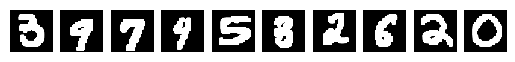

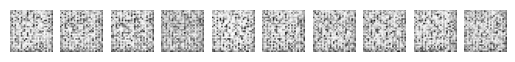

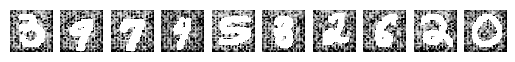

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Autoencoder reconstruction error (infinity to 0): 690.301
Counterfactual prediction gain (0 to 1): 0.000
Sparsity (L1, infinity to 0): 0.521
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
float16
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


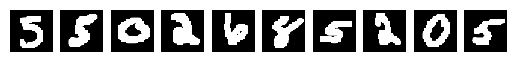

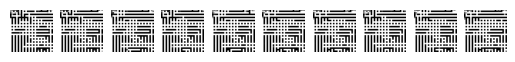

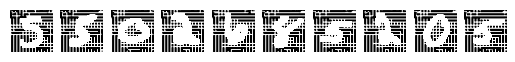

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Autoencoder reconstruction error (infinity to 0): 708.918
Counterfactual prediction gain (0 to 1): 0.000
Sparsity (L1, infinity to 0): 0.985
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
float16
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


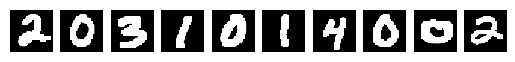

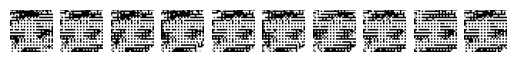

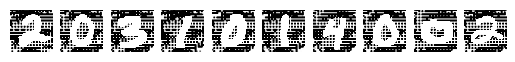

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Autoencoder reconstruction error (infinity to 0): 709.262
Counterfactual prediction gain (0 to 1): 0.000
Sparsity (L1, infinity to 0): 0.987
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
float16
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


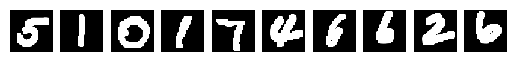

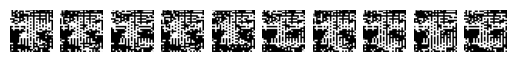

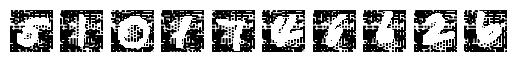

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Autoencoder reconstruction error (infinity to 0): 714.321
Counterfactual prediction gain (0 to 1): 0.000
Sparsity (L1, infinity to 0): 0.994
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
float16
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


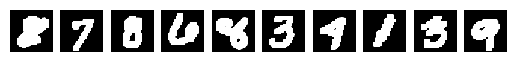

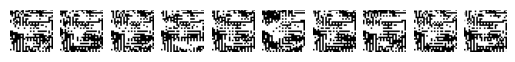

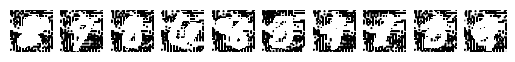

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Autoencoder reconstruction error (infinity to 0): 711.174
Counterfactual prediction gain (0 to 1): 0.000
Sparsity (L1, infinity to 0): 0.995
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
float16
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


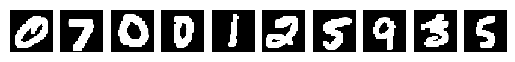

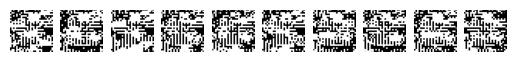

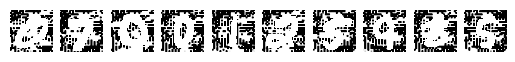

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Autoencoder reconstruction error (infinity to 0): 711.349
Counterfactual prediction gain (0 to 1): 0.000
Sparsity (L1, infinity to 0): 0.993
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
float16
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


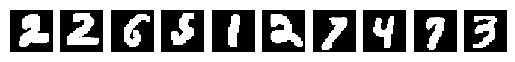

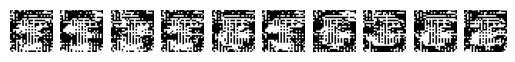

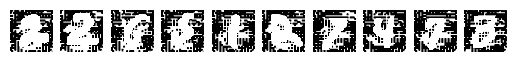

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Autoencoder reconstruction error (infinity to 0): 713.463
Counterfactual prediction gain (0 to 1): 0.000
Sparsity (L1, infinity to 0): 0.994
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
float16
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


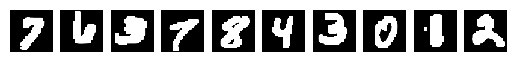

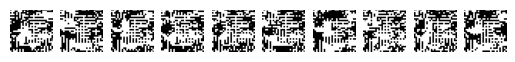

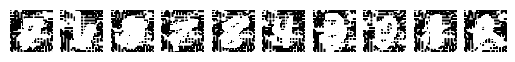

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Autoencoder reconstruction error (infinity to 0): 710.021
Counterfactual prediction gain (0 to 1): 0.000
Sparsity (L1, infinity to 0): 0.993
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
float16
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


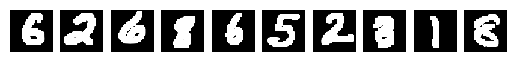

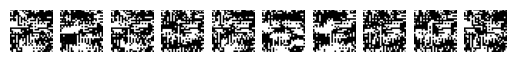

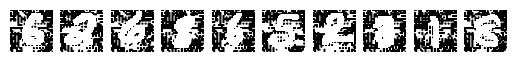

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Autoencoder reconstruction error (infinity to 0): 714.990
Counterfactual prediction gain (0 to 1): 0.000
Sparsity (L1, infinity to 0): 0.992
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
float16
 49/313 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step

KeyboardInterrupt: 

In [18]:
target_class = 8
infinite_train_ds = infinite_data_stream(train_dataset)

countergan = ctf.train_countergan(
                                countergan, 
                                cnn, 
                                disc, 
                                gen, 
                                autoencoder, 
                                infinite_train_ds,
                                test_data.data.numpy(),
                                num_classes,
                                target_class,   
                                weighted_version=False, 
                                n_iterations=10000, 
                                n_discriminator_steps=2,
                                n_generator_steps=3,
                                )